# **Naive Bayes Classifier**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# **Preprocessing**

##### prepares the dataset by handling missing values, scaling features, and removing outliers, followed by data splitting for further analysis or modeling.

In [3]:
# Read the combined dataset
combined_df = pd.read_csv("combined_data_with_id_ordered.csv")

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values:\n", missing_values)

# Convert 'timestamp' column to datetime format
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Perform feature scaling
columns_to_scale = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
scaler = StandardScaler()
combined_df[columns_to_scale] = scaler.fit_transform(combined_df[columns_to_scale])


# Display the first few rows of the modified DataFrame
print("\nModified DataFrame:")
print(combined_df.head())

# Function to detect and remove extreme outliers using the IQR method with a lower multiplier
def remove_extreme_outliers_iqr(df, columns, multiplier=6):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


# Apply the outlier removal function to the relevant columns with a higher multiplier
columns_to_check = columns_to_scale  # The same columns that were scaled
original_shape = combined_df.shape
cleaned_df = remove_extreme_outliers_iqr(combined_df, columns_to_check, multiplier=6)
cleaned_shape = cleaned_df.shape

# Display the first few rows of the cleaned DataFrame
print("\nCleaned DataFrame:")
print(cleaned_df.head())

# Display the number of rows before and after removing outliers
print("\nOriginal number of rows:", original_shape[0])
print("Number of rows after removing outliers:", cleaned_shape[0])


# Select features and target
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X = cleaned_df[features]
y = cleaned_df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'combined_data_with_id_ordered.csv'

### **Training GNB model on original data**

In [4]:
# Train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train,y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

print("Accuracy in original data with removing outliers :", accuracy_score(y_test, y_pred))
print("F1 in original data with removing outliers :", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report in original with removing outliers:\n", classification_report(y_test, y_pred,zero_division=1))

Accuracy in original data with removing outliers : 0.7799935536369113
F1 in original data with removing outliers : 0.7603558931162435
Classification Report in original with removing outliers:
               precision    recall  f1-score   support

           1       0.64      0.58      0.61    349545
           2       0.50      0.54      0.52     61082
           3       0.17      0.10      0.12     76522
           4       1.00      0.00      0.00     22897
           5       1.00      0.00      0.00     19977
           6       0.57      0.93      0.71    222180
           7       0.97      0.98      0.97    870943
           8       0.92      0.98      0.95    119333
          13       0.61      0.48      0.54    118342
          14       0.36      0.14      0.20     16826
         130       1.00      0.00      0.00     12495
         140       0.06      0.00      0.00      2398

    accuracy                           0.78   1892540
   macro avg       0.65      0.39      0.39   189

##### while the Naive Bayes classifier achieves reasonable performance on the majority classes, there is room for improvement, particularly for the minority classes with lower precision and recall values. Further enhancement performance, especially for the minority classes.

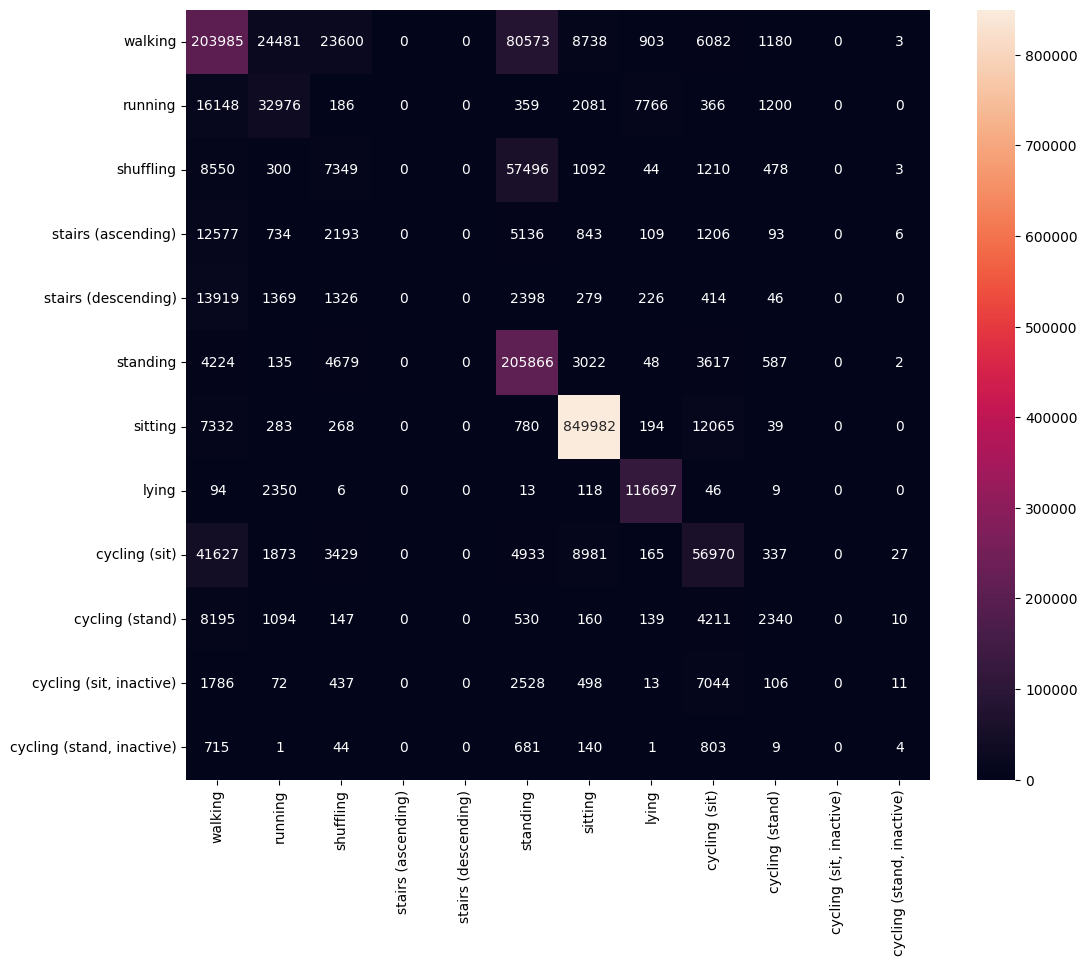

In [5]:
# Assuming y_test and y_pred are defined and cf_matrix is computed
cf_matrix = confusion_matrix(y_test, y_pred)

# Define the new labels
labels = [
    'walking', 'running', 'shuffling', 'stairs (ascending)',
    'stairs (descending)', 'standing', 'sitting', 'lying',
    'cycling (sit)', 'cycling (stand)', 'cycling (sit, inactive)',
    'cycling (stand, inactive)'
]

# Adjust the figure size if necessary
plt.figure(figsize=(12, 10))

# Plot the heatmap with the new labels
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='g')

# Display the plot
plt.show()


##### The confusion matrix highlighted misclassifications among similar activities, such as different cycling modes and dynamic activities like running and shuffling. 

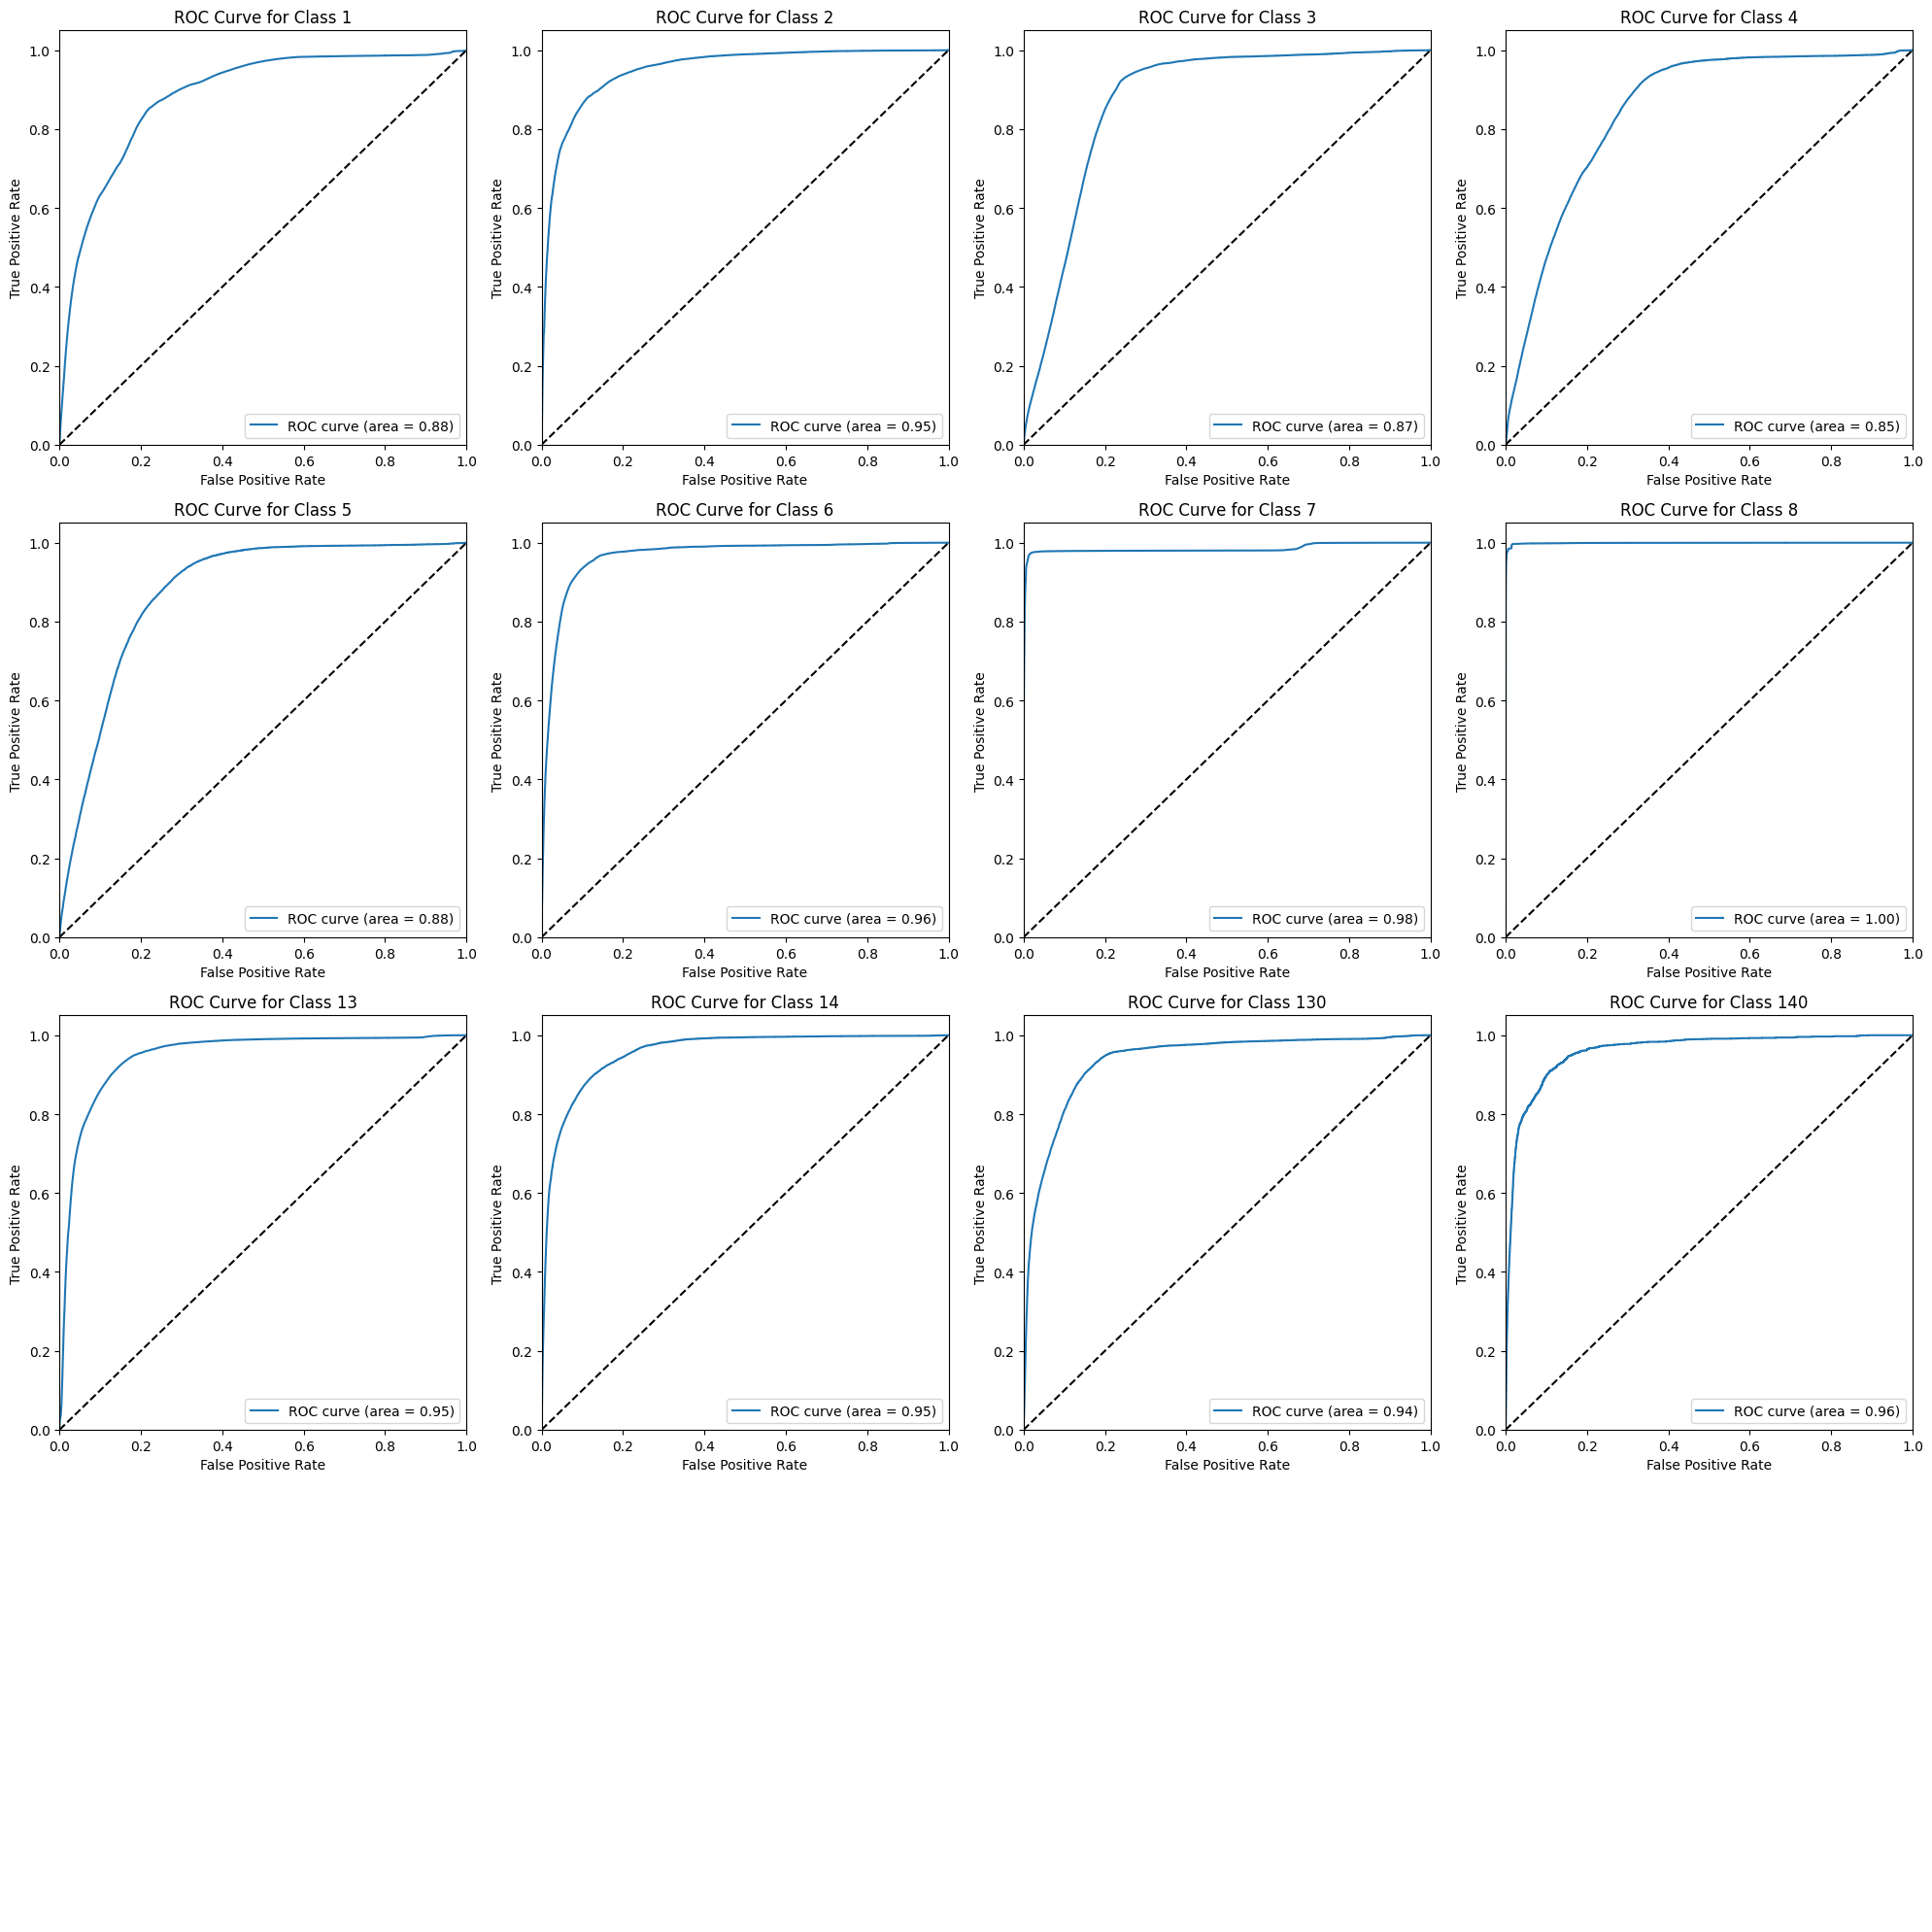

In [6]:
import numpy as np
from sklearn.metrics import auc

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = model.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves in a 4x4 matrix
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < n_classes:
        ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for Class {np.unique(y_test)[i]}')
        ax.legend(loc="lower right")
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout()
plt.show()


### **Hyperparameter Tuning to find model parameters**

In [7]:
from sklearn.model_selection import GridSearchCV


param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid = param_grid_nb, cv = 5)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

GaussianNB(var_smoothing=8.111308307896872e-07)


In [8]:
y_pred = nbModel_grid.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
print(f1_score(y_test, y_pred, average='weighted'))

0.7799935536369113
              precision    recall  f1-score   support

           1       0.64      0.58      0.61    349545
           2       0.50      0.54      0.52     61082
           3       0.17      0.10      0.12     76522
           4       1.00      0.00      0.00     22897
           5       1.00      0.00      0.00     19977
           6       0.57      0.93      0.71    222180
           7       0.97      0.98      0.97    870943
           8       0.92      0.98      0.95    119333
          13       0.61      0.48      0.54    118342
          14       0.36      0.14      0.20     16826
         130       1.00      0.00      0.00     12495
         140       0.06      0.00      0.00      2398

    accuracy                           0.78   1892540
   macro avg       0.65      0.39      0.39   1892540
weighted avg       0.78      0.78      0.76   1892540



After tuning, the optimal 'var_smoothing' parameter was found to be 0.02848, slightly improving the accuracy to 77.19% and the weighted F1-score to 75.64%.

### **undersampling**

Different resampling methods were evaluated to handle class imbalance

In [9]:
# Apply different resampling techniques
resampling_methods = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}

for method_name, method in resampling_methods.items():
    print(f"\nEvaluating model with {method_name}")

    # Resample the training data
    X_resampled, y_resampled = method.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    # Train the Naive Bayes model
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Predictions on test data
    y_pred_test = model.predict(X_test)

    # Evaluate the model
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy with {method_name}: {accuracy_test}")
    print(f1_score(y_test, y_pred_test, average='weighted'))
    print(f"Classification Report with {method_name}:")
    print(classification_report(y_test, y_pred_test, zero_division=1))


# Train and evaluate the model on original data for comparison
model_original = GaussianNB()
model_original.fit(X_train, y_train)
y_pred_test_original = model_original.predict(X_test)
accuracy_test_original = accuracy_score(y_test, y_pred_test_original)

print("\nAccuracy with Original Data:", accuracy_test_original)
print(f1_score(y_test, y_pred_test_original, average='weighted'))
print("Classification Report with Original Data:")
print(classification_report(y_test, y_pred_test_original, zero_division=1))


Evaluating model with RandomUnderSampler
Accuracy with RandomUnderSampler: 0.5027565733672604
0.4710605989216914
Classification Report with RandomUnderSampler:
              precision    recall  f1-score   support

           1       0.28      0.08      0.12      2311
           2       0.60      0.62      0.61      2339
           3       0.23      0.21      0.22      2303
           4       0.29      0.15      0.20      2321
           5       0.41      0.21      0.28      2484
           6       0.44      0.89      0.59      2382
           7       0.88      0.97      0.92      2385
           8       0.88      0.97      0.92      2324
          13       0.50      0.31      0.38      2390
          14       0.61      0.52      0.56      2401
         130       0.31      0.34      0.32      2309
         140       0.39      0.75      0.52      2347

    accuracy                           0.50     28296
   macro avg       0.48      0.50      0.47     28296
weighted avg       0.49    

The best performance was achieved with SMOTE, yielding an accuracy of 48.65% and a weighted F1-score of 45.75%. Although the accuracy decreased compared to the original model, resampling improved the model's ability to recognize minority classes, as reflected in the balanced precision and recall scores across all activities.


## Manual Sampling using weights 

In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Define the desired class weights
class_weights = {
    7: 0.009,  # decrease weight for class 7
    1: 1,      # Maintain original weight for class 1
    6: 0.4,    # Slightly decrease weight for class 6
    8: 0.009,  # decrease weight for class 8
    13: 1,    # Maintain original weight for class 13
    2: 1,     # Maintain original weight for class 2
    3: 1,     # Maintain original weight for class 3
    4: 7,     # increase weight for class 4
    5: 8,     # increase weight for class 5
    14: 1,    # Maintain original weight for class 14
    130: 3,   # Slightly increase weight for class 130
    140: 2    # Slightly increase weight for class 140
}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gaussian Naive Bayes model with adjusted class weights
model = GaussianNB(priors=None, var_smoothing=1e-09)
model.fit(X_train, y_train, sample_weight=y_train.map(class_weights))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, zero_division=1)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)


Accuracy: 0.6869119508469969
F1 Score: 0.7000803829438504
Classification Report:
               precision    recall  f1-score   support

           1       0.51      0.58      0.54    233462
           2       0.39      0.64      0.49     40698
           3       0.18      0.18      0.18     51008
           4       0.10      0.13      0.11     15243
           5       0.10      0.05      0.06     13437
           6       0.62      0.90      0.73    148054
           7       1.00      0.78      0.88    579947
           8       1.00      0.84      0.91     79695
          13       0.37      0.45      0.40     79042
          14       0.34      0.12      0.18     11302
         130       0.15      0.18      0.17      8216
         140       0.12      0.12      0.12      1589

    accuracy                           0.69   1261693
   macro avg       0.41      0.41      0.40   1261693
weighted avg       0.74      0.69      0.70   1261693



the Gaussian Naive Bayes model with adjusted class weights shows an improvement in overall performance, particularly in handling imbalanced classes.